In [1]:
!pip install git+https://github.com/Qip21n0/Lassolver.git

  Cloning https://github.com/Qip21n0/Lassolver.git to /tmp/pip-req-build-j58k4d6h
  Running command git clone -q https://github.com/Qip21n0/Lassolver.git /tmp/pip-req-build-j58k4d6h
  Created wheel for lassolver: filename=lassolver-0.2.6-py3-none-any.whl size=14036 sha256=84fad276ee6c321c66f1467d306f7e17511ef19f7a8a815d42fdb7f019d7daa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-iia23h0h/wheels/5c/0b/77/92d6595822ec0c5e1c27d209f3bcae9296385c30ce4a38cf06
Successfully built lassolver


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP
from lassolver.dsolver.d_base import dbase, D_Base

In [3]:
!pip show lassolver

Name: lassolver
Version: 0.2.7
Summary: Lassolver is a Python package for Compressed Sensing and Distributed Compressed Sensing
Home-page: https://github.com/Qip21n0/Lassolver
Author: Ken Hisanaga
Author-email: UNKNOWN
License: MIT
Location: /home/ryota/.local/lib/python3.8/site-packages
Requires: matplotlib, scipy, numpy
Required-by: 


In [4]:
def gcoamp(w, tau_p, log=False, ord=None):
    shita = 0.7
    tau = np.sum(tau_p)
    communication_cost = 0
    P, N, _ = w.shape
    R = np.zeros((P, N, 1))
    z = [0] * N
    
    #STEP1
    for p in range(1, P):
        R[p] = np.square(w[p]) > tau_p[p] * shita
        candidate = np.where(R[p])[0]
        for n in candidate:
            communication_cost += 1
            send_to1(n, w[p, n])
    
    #STEP2
    S = [np.where(R[:, n])[0] for n in range(N)]
    m = np.sum(R, axis=0)
    U = np.empty((N, 1))
    for n in range(N):
        upper = np.sum([tau_p[p] for p in range(1, P) if p not in S[p]])
        z[n] = w[0, n] + np.sum([w[p, n] for p in S[n]])
        U[n] = z[n]**2 + upper * shita
    F = (U > tau) * (m < (P-1))
    candidate = np.where(F)[0]
    for n in candidate:
        communication_cost += 1
        broadcast_others(n)
    
    #STEP3
    F_R = F * np.logical_not(R)
    for p in range(1, P):
        #print("p: {}".format(p))
        candidate = np.where(F_R[p])[0]
        for n in candidate:
            communication_cost += 1
            send_to1(n ,w[p, n])
    if log: 
        print("Rp: {} \t F: {} \t F\\Rp: {}".format(np.sum(R), np.sum(F), np.sum(F_R)-np.sum(F)))
        print("Total Communication Cost: {}".format(communication_cost))
        print("="*50)
    
    #STEP4
    u = np.zeros((N, 1))
    b = np.zeros((N, 1))
    V = np.where(U > tau)[0].tolist()
    for n in V:
        b[n] = np.sum(w[:, n])
        u[n] = soft_threshold(b[n], tau**0.5)
    
    #STEP5
    Vc = [n for n in range(N) if n not in V]
    z_exe = {'0', '1'}
    rand_exe = {'0', '2'}
    for n in Vc:
        b[n] = z[n] if ord in z_exe else 0
        b[n] += np.sum([rand(shita * tau_p[p]) for p in range(1, P) if p not in S[n]]) if ord in rand_exe else 0
        b[n] = np.sum([w[p, n] for p in range(1, P) if p not in S[n]]) if ord == '4' else b[n]
        
    s = u - np.mean(u != 0)*b
    return s.real, communication_cost

In [5]:
class dtest(dbase):
    def __init__(self, A_p, x, snr, M):
        super().__init__(A_p, x, snr, M)

    def receive_s(self, s):
        self.s = s.copy()

    def receive_W_p(self, W_p):
        self.W_p = W_p.copy()

    def receive_trX2(self, trW_p2, trB2):
        self.trW_p2 = trW_p2
        self.trB2 = trB2

    def receive_trA2(self, trA2):
        self.trA2 = trA2

    def local_compute(self):
        self.r_p = self._update_r_p()
        w_p = self._update_w_p()
        v_p = self._update_v_p()
        tau_p = self._update_tau_p(v_p)
        return w_p, v_p, tau_p

    def _update_r_p(self):
        return self.y - self.A_p @ self.s

    def _update_w_p(self):
        return self.s / self.P + self.W_p @ self.r_p

    def _update_v_p(self):
        v_p = (np.linalg.norm(self.r_p)**2 - self.M_p * self.sigma_p) / self.trA2
        return v_p

    def _update_tau_p(self, v_p):
        return 1 / self.N * (self.trB2 * v_p + self.trW_p2 * self.sigma_p)

In [6]:
class D_Test(D_Base):
    def __init__(self, A, x, noise, P):
        super().__init__(A, x, noise, P)
        self.A = A.copy()
        self.AT = self.A.T
        self.AAT = self.A @ self.AT
        self.I = np.eye(self.M)
        self.c = (self.N - self.M) / self.M
        self.oamps = [dtest(self.A_p[p], x, self.noise[p], self.M) for p in range(self.P)]
        self.sigma = self.__set_sigma()
        self.trA2 = self.__set_trA2()

    def __set_sigma(self):
        sigma = 0
        for p in range(self.P):
            sigma += self.oamps[p].sigma_p
        return sigma / self.P
    
    def __set_trA2(self):
        trA2 = 0
        for p in range(self.P):
            trA2 += self.oamps[p].trA2_p
        return trA2

    def estimate(self, T=20, C=1.85, ord='LMMSE', log=False, gctype=None):
        self.gctype = gctype
        w = np.zeros((self.P, self.N, 1))

        v = (np.sum([np.linalg.norm(self.oamps[p].y)**2 for p in range(self.P)]) - self.M_p * self.sigma) / self.trA2
        self.W = self.__set_W(v, ord)
        self.W_p = self.W.T.reshape(self.P, self.M_p, self.N)
        
        I = np.eye(self.N)
        B = I - self.W @ self.A
        self.trW2 = [np.trace(W_p.T @ W_p) for W_p in self.W_p]
        self.trB2 = np.trace(B @ B.T)

        for p in range(self.P):
            self.oamps[p].receive_W_p(self.W_p[p].T)
            self.oamps[p].receive_trX2(self.trW2[p], self.trB2)
            self.oamps[p].receive_trA2(self.trA2)
        
        for t in range(T):
            for p in range(self.P):
                w[p], self.v_p[p], self.tau_p[p] = self.oamps[p].local_compute()
            #w[0] += self.s
            v = self._update_v()
            tau = self._update_tau()
            if log: print("{}/{}: tau = {}, v = {}".format(t+1, T, tau, v))
            self._update_s(C, w, log)

            for p in range(self.P):
                self.oamps[p].receive_s(self.s)
            self._add_mse()
            if t == T-1: break
            if ord == 'LMMSE':
                self.W = self.__set_W(v, ord='LMMSE')
                self.W_p = self.W.T.reshape(self.P, self.M_p, self.N)
                B = I - self.W @ self.A
                self.trW2 = [np.trace(W_p.T @ W_p) for W_p in self.W_p]
                self.trB2 = np.trace(B @ B.T)
                for p in range(self.P):
                    self.oamps[p].receive_W_p(self.W_p[p].T)
                    self.oamps[p].receive_trX2(self.trW2[p], self.trB2)
        
        #self._output_s(w, log)
        #self._add_mse()

    def __set_W(self, v, ord):
        if ord == 'MF':
            W_ = self.AT
        elif ord == 'PINV':
            W_ = np.linalg.pinv(self.A)
        elif ord == 'LMMSE':
            W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
        else :
            raise NameError("not correct")
        return self.N / np.trace(W_ @ self.A) * W_

    def _update_v(self):
        #r2 = np.sum(self.r2)
        #v = (r2 - self.M * self.sigma) / self.trA2
        v = np.sum(self.v_p)
        v = v if v > 0 else 1e-4
        self.v.append(v)
        return v

    def _update_tau(self):
        #return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)
        return np.sum(self.tau_p)

    def _update_s(self, C, w, log):
        s, communication_cost = gcoamp(w, self.tau_p, log, self.gctype)
        self.s = C * s
        self.communication_cost = np.append(self.communication_cost, communication_cost)

    def _output_s(self, w, log):
        s, communication_cost = GCAMP(w, self.tau_p, log)
        self.s = s
        self.communication_cost = np.append(self.communication_cost, communication_cost)

In [7]:
N = 1000
alpha = 0.5
M = int(alpha*N)
rho = 0.2

In [8]:
kappa = 5
P = 2
T = 40

In [9]:
x = bernouli_gaussian(N, rho)
SNR = 30
mode = 'LMMSE'

In [10]:
iidG = iidGaussian(M, N, 0, 1/M)
SNRdB = 10**(0.1*SNR)
sigma = np.var(iidG.A @ x) / SNRdB
noise = np.random.normal(0, sigma**0.5, (M, 1))

In [11]:
oamp = OAMP(iidG.A, x, noise)
test = [D_Test(iidG.A, x, noise, P) for _ in range(5)]

In [12]:
%%prun
oamp.estimate(T=T, ord=mode)

         4506 function calls (4345 primitive calls) in 2.530 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.205    1.205    2.529    2.529 oamp.py:13(estimate)
       40    0.679    0.017    1.203    0.030 oamp.py:40(__set_W)
       40    0.516    0.013    0.517    0.013 linalg.py:476(inv)
       40    0.040    0.001    0.040    0.001 ista.py:39(_update_r)
       40    0.037    0.001    0.037    0.001 oamp.py:51(_update_w)
       40    0.019    0.000    0.019    0.000 {built-in method numpy.zeros}
      161    0.009    0.000    0.009    0.000 {method 'trace' of 'numpy.ndarray' objects}
  523/362    0.003    0.000    0.539    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
      161    0.002    0.000    0.013    0.000 fromnumeric.py:1650(trace)
       81    0.002    0.000    0.003    0.000 linalg.py:2363(norm)
       40    0.002    0.000    0.022    0.001 twodim_base.py:161(eye)


final mse: 0.015547941320487911


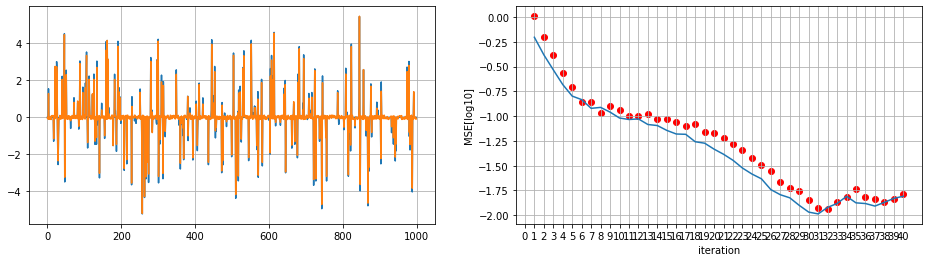

In [13]:
oamp.result()

## $z[n]$と乱数を含む手法(現提案手法)

In [14]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[0].estimate(T=T, ord=mode, log=True, gctype='0')

N(P-1): 1000

1/40: tau = 1.0232690018022939, v = 1.0189723805700786
Rp: 604.0 	 F: 133 	 F\Rp: 133
Total Communication Cost: 870
2/40: tau = 0.5590170425230436, v = 0.5547245997768625
Rp: 606.0 	 F: 168 	 F\Rp: 168
Total Communication Cost: 942
3/40: tau = 0.34690138166521, v = 0.3426187661471727
Rp: 624.0 	 F: 120 	 F\Rp: 120
Total Communication Cost: 864
4/40: tau = 0.226459278251033, v = 0.2221898816855649
Rp: 617.0 	 F: 161 	 F\Rp: 161
Total Communication Cost: 939
5/40: tau = 0.18644333968326698, v = 0.18218610146467626
Rp: 642.0 	 F: 147 	 F\Rp: 147
Total Communication Cost: 936
6/40: tau = 0.15832590747625191, v = 0.15407767347872336
Rp: 635.0 	 F: 153 	 F\Rp: 153
Total Communication Cost: 941
7/40: tau = 0.14095834371589488, v = 0.13671778796386247
Rp: 647.0 	 F: 140 	 F\Rp: 140
Total Communication Cost: 927
8/40: tau = 0.1322831740553188, v = 0.12804739077073674
Rp: 639.0 	 F: 151 	 F\Rp: 151
Total Communication Cost: 941
9/40: tau = 0.10918333893196655, v = 0.104959885687385

         2948029 function calls (2947735 primitive calls) in 7.765 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       40    0.976    0.024    5.156    0.129 1962848297.py:1(gcoamp)
        1    0.945    0.945    7.763    7.763 2242291230.py:25(estimate)
   177571    0.809    0.000    0.809    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       40    0.731    0.018    0.994    0.025 2242291230.py:69(__set_W)
       39    0.431    0.011    0.438    0.011 2242291230.py:60(<listcomp>)
   177531    0.362    0.000    1.391    0.000 fromnumeric.py:69(_wrapreduction)
    40000    0.319    0.000    0.319    0.000 1962848297.py:22(<listcomp>)
294695/294413    0.291    0.000    2.484    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       40    0.259    0.006    0.260    0.006 linalg.py:476(inv)
     9535    0.203    0.000    0.564    0.000 _continuous_distns.py:8003(_truncnorm_ppf_scalar)
   12

final mse: 0.006662085280325191


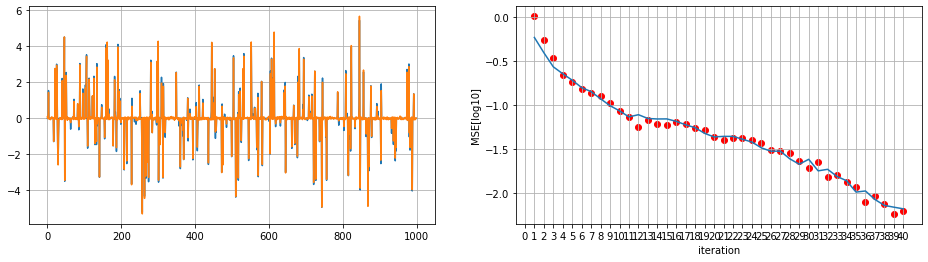

In [15]:
test[0].result()

## $z[n]$は含むが, 乱数は含まない手法

In [16]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[1].estimate(T=T, ord=mode, log=True, gctype='1')

N(P-1): 1000

1/40: tau = 1.0232690018022939, v = 1.0189723805700786
Rp: 604.0 	 F: 133 	 F\Rp: 133
Total Communication Cost: 870
2/40: tau = 0.5277769360223278, v = 0.5234847744517092
Rp: 615.0 	 F: 165 	 F\Rp: 165
Total Communication Cost: 945
3/40: tau = 0.37753765713933973, v = 0.37325472397110565
Rp: 628.0 	 F: 116 	 F\Rp: 116
Total Communication Cost: 860
4/40: tau = 0.20002940758101811, v = 0.19576012178771302
Rp: 628.0 	 F: 155 	 F\Rp: 155
Total Communication Cost: 938
5/40: tau = 0.1803144396897955, v = 0.1760599262311977
Rp: 644.0 	 F: 155 	 F\Rp: 155
Total Communication Cost: 954
6/40: tau = 0.15427008470036857, v = 0.1500234550161237
Rp: 642.0 	 F: 146 	 F\Rp: 146
Total Communication Cost: 934
7/40: tau = 0.1556482618163416, v = 0.15140232783057433
Rp: 649.0 	 F: 126 	 F\Rp: 126
Total Communication Cost: 901
8/40: tau = 0.12584770999034361, v = 0.12161308861241811
Rp: 645.0 	 F: 153 	 F\Rp: 153
Total Communication Cost: 951
9/40: tau = 0.11222822394450617, v = 0.10800408066

         1254554 function calls (1254272 primitive calls) in 5.869 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.900    0.900    5.868    5.868 2242291230.py:25(estimate)
       40    0.816    0.020    3.117    0.078 1962848297.py:1(gcoamp)
       40    0.710    0.018    1.322    0.033 2242291230.py:69(__set_W)
       40    0.608    0.015    0.608    0.015 linalg.py:476(inv)
   100815    0.555    0.000    0.555    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       39    0.361    0.009    0.368    0.009 2242291230.py:60(<listcomp>)
    40000    0.325    0.000    0.325    0.000 1962848297.py:22(<listcomp>)
   100775    0.268    0.000    0.961    0.000 fromnumeric.py:69(_wrapreduction)
   100775    0.190    0.000    1.180    0.000 fromnumeric.py:2123(sum)
141659/141377    0.170    0.000    1.975    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       40    0.143    0.004   

final mse: 0.005586122013534853


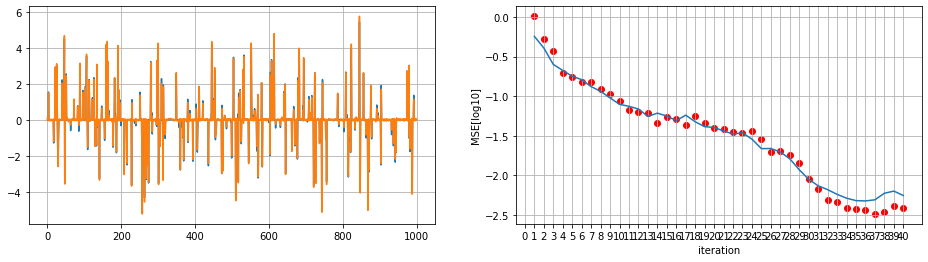

In [17]:
test[1].result()

## $z[n]$は含まないが, 乱数は含む手法

In [18]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[2].estimate(T=T, ord=mode, log=True, gctype='2')

N(P-1): 1000

1/40: tau = 1.0232690018022939, v = 1.0189723805700786
Rp: 604.0 	 F: 133 	 F\Rp: 133
Total Communication Cost: 870
2/40: tau = 0.34582095985008127, v = 0.34153043596830884
Rp: 626.0 	 F: 160 	 F\Rp: 160
Total Communication Cost: 946
3/40: tau = 0.3528278493569197, v = 0.34854863928537216
Rp: 627.0 	 F: 117 	 F\Rp: 117
Total Communication Cost: 861
4/40: tau = 0.14015507434823346, v = 0.1358918387971974
Rp: 625.0 	 F: 151 	 F\Rp: 151
Total Communication Cost: 927
5/40: tau = 0.15742596831938308, v = 0.1531784968190775
Rp: 642.0 	 F: 107 	 F\Rp: 107
Total Communication Cost: 856
6/40: tau = 0.10764903977460438, v = 0.10342091364905237
Rp: 634.0 	 F: 151 	 F\Rp: 151
Total Communication Cost: 936
7/40: tau = 0.12837449691271008, v = 0.12413849462064402
Rp: 648.0 	 F: 107 	 F\Rp: 107
Total Communication Cost: 862
8/40: tau = 0.07498353681469011, v = 0.07077971403015065
Rp: 630.0 	 F: 166 	 F\Rp: 166
Total Communication Cost: 962
9/40: tau = 0.1031281126579959, v = 0.098900093

         2785212 function calls (2784930 primitive calls) in 7.688 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.019    1.019    7.686    7.686 2242291230.py:25(estimate)
       40    0.881    0.022    4.830    0.121 1962848297.py:1(gcoamp)
       40    0.790    0.020    1.198    0.030 2242291230.py:69(__set_W)
   171265    0.777    0.000    0.777    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       39    0.441    0.011    0.447    0.011 2242291230.py:60(<listcomp>)
       40    0.403    0.010    0.404    0.010 linalg.py:476(inv)
   171225    0.359    0.000    1.352    0.000 fromnumeric.py:69(_wrapreduction)
    40000    0.336    0.000    0.336    0.000 1962848297.py:22(<listcomp>)
279981/279699    0.284    0.000    2.551    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   120321    0.222    0.000    1.367    0.000 fromnumeric.py:2123(sum)
     8484    0.174    0.000   

final mse: 0.08610414711112314


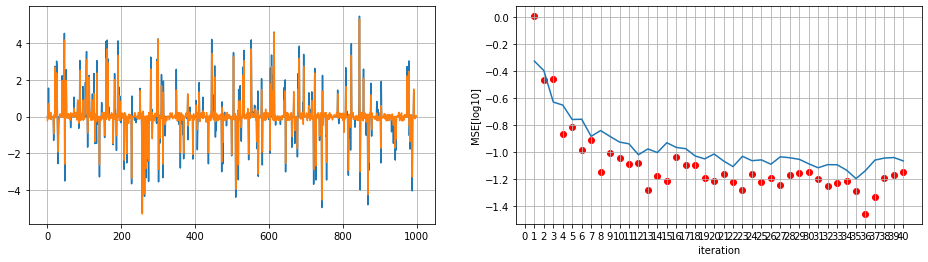

In [19]:
test[2].result()

## $z[n]$も乱数も含まない手法

In [20]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[3].estimate(T=T, ord=mode, log=True, gctype='3')

N(P-1): 1000

1/40: tau = 1.0232690018022939, v = 1.0189723805700786
Rp: 604.0 	 F: 133 	 F\Rp: 133
Total Communication Cost: 870
2/40: tau = 0.324153603308386, v = 0.3198632744429515
Rp: 632.0 	 F: 162 	 F\Rp: 162
Total Communication Cost: 956
3/40: tau = 0.34098270187368596, v = 0.33670434861568155
Rp: 625.0 	 F: 119 	 F\Rp: 119
Total Communication Cost: 863
4/40: tau = 0.13499997997813534, v = 0.13073824725776473
Rp: 650.0 	 F: 167 	 F\Rp: 167
Total Communication Cost: 984
5/40: tau = 0.1682003494185801, v = 0.16394675350827642
Rp: 662.0 	 F: 149 	 F\Rp: 149
Total Communication Cost: 960
6/40: tau = 0.15616793924292058, v = 0.15192151706449708
Rp: 651.0 	 F: 145 	 F\Rp: 145
Total Communication Cost: 941
7/40: tau = 0.11462003168246407, v = 0.11038956816911283
Rp: 636.0 	 F: 153 	 F\Rp: 153
Total Communication Cost: 942
8/40: tau = 0.09935391704802729, v = 0.0951395873921892
Rp: 681.0 	 F: 137 	 F\Rp: 137
Total Communication Cost: 955
9/40: tau = 0.0924910025494286, v = 0.08828454452

         1274876 function calls (1274594 primitive calls) in 5.854 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.917    0.917    5.854    5.854 2242291230.py:25(estimate)
       40    0.759    0.019    1.354    0.034 2242291230.py:69(__set_W)
       40    0.738    0.018    3.023    0.076 1962848297.py:1(gcoamp)
       40    0.590    0.015    0.591    0.015 linalg.py:476(inv)
   102594    0.530    0.000    0.530    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       39    0.381    0.010    0.387    0.010 2242291230.py:60(<listcomp>)
    40000    0.298    0.000    0.298    0.000 1962848297.py:22(<listcomp>)
   102554    0.258    0.000    0.927    0.000 fromnumeric.py:69(_wrapreduction)
       40    0.200    0.005    0.200    0.005 1962848297.py:53(<listcomp>)
   102554    0.184    0.000    1.134    0.000 fromnumeric.py:2123(sum)
143438/143156    0.167    0.000    1.911    0.000 {built-in method numpy.core

final mse: 0.08037400751643581


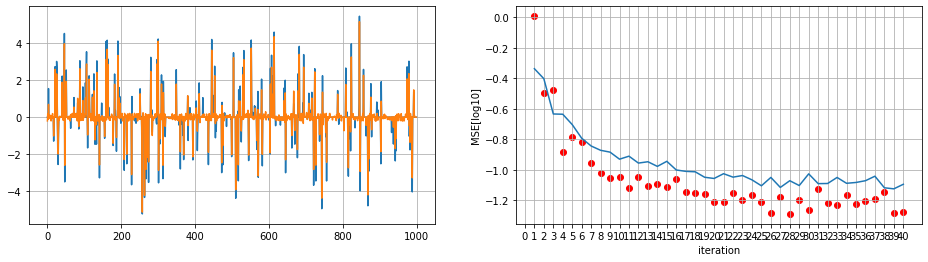

In [21]:
test[3].result()

## イレギュラーな値$b[n] = \sum_{p \ge 2, p \notin S_n} w^t_p [n]$を用いる手法

In [22]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[4].estimate(T=T, ord=mode, log=True, gctype='4')

N(P-1): 1000

1/40: tau = 1.0232690018022939, v = 1.0189723805700786
Rp: 604.0 	 F: 133 	 F\Rp: 133
Total Communication Cost: 870
2/40: tau = 0.3587388879027587, v = 0.35444824775359496
Rp: 621.0 	 F: 117 	 F\Rp: 117
Total Communication Cost: 855
3/40: tau = 0.2916665756509552, v = 0.2873918115588932
Rp: 631.0 	 F: 117 	 F\Rp: 117
Total Communication Cost: 865
4/40: tau = 0.13653160135430994, v = 0.13227494127846298
Rp: 643.0 	 F: 169 	 F\Rp: 169
Total Communication Cost: 981
5/40: tau = 0.1897100690572609, v = 0.18544626523417837
Rp: 645.0 	 F: 147 	 F\Rp: 147
Total Communication Cost: 939
6/40: tau = 0.12532938713133135, v = 0.12108936021295649
Rp: 652.0 	 F: 153 	 F\Rp: 153
Total Communication Cost: 958
7/40: tau = 0.14480787217923213, v = 0.1405648560838552
Rp: 644.0 	 F: 141 	 F\Rp: 141
Total Communication Cost: 926
8/40: tau = 0.100082037742161, v = 0.0958600891690092
Rp: 643.0 	 F: 155 	 F\Rp: 155
Total Communication Cost: 953
9/40: tau = 0.11428185345152388, v = 0.1100556194208

         1470047 function calls (1469765 primitive calls) in 5.955 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       40    0.868    0.022    3.431    0.086 1962848297.py:1(gcoamp)
        1    0.859    0.859    5.954    5.954 2242291230.py:25(estimate)
       40    0.704    0.018    1.077    0.027 2242291230.py:69(__set_W)
   120361    0.659    0.000    0.659    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       39    0.397    0.010    0.404    0.010 2242291230.py:60(<listcomp>)
       40    0.368    0.009    0.369    0.009 linalg.py:476(inv)
    40000    0.327    0.000    0.327    0.000 1962848297.py:22(<listcomp>)
   120321    0.290    0.000    1.108    0.000 fromnumeric.py:69(_wrapreduction)
   120321    0.219    0.000    1.355    0.000 fromnumeric.py:2123(sum)
161205/160923    0.188    0.000    1.929    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       40    0.133    0.003   

final mse: 0.06502916511139804


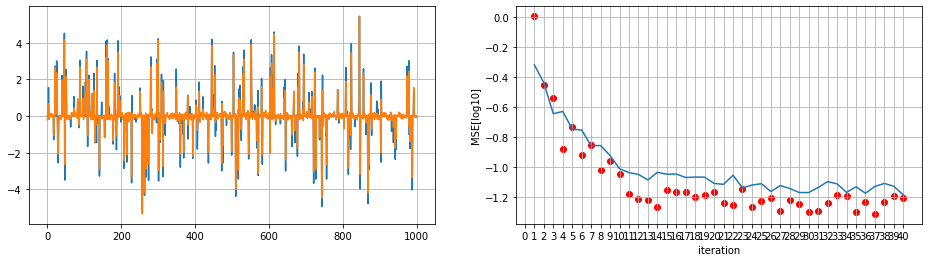

In [23]:
test[4].result()

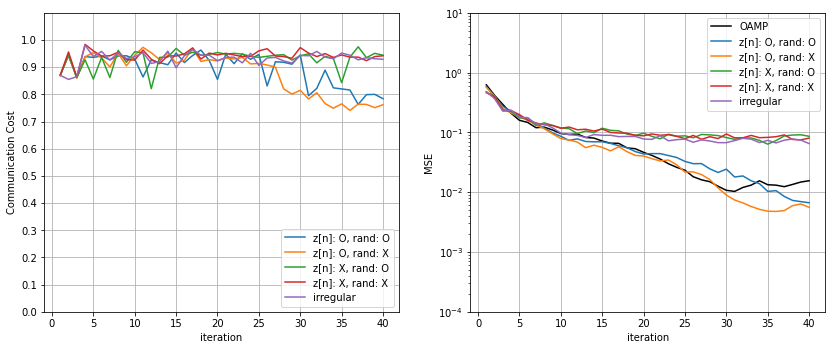

In [24]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt_CC(test[0].communication_cost, 'z[n]: O, rand: O', T, N, P)
plt_CC(test[1].communication_cost, 'z[n]: O, rand: X', T, N, P)
plt_CC(test[2].communication_cost, 'z[n]: X, rand: O', T, N, P)
plt_CC(test[3].communication_cost, 'z[n]: X, rand: X', T, N, P)
plt_CC(test[4].communication_cost, 'irregular', T, N, P)
plt.grid()

plt.subplot(122)
plt_MSE(oamp.mse, 'OAMP', T, 'black')
plt_MSE(test[0].mse, 'z[n]: O, rand: O', T)
plt_MSE(test[1].mse, 'z[n]: O, rand: X', T)
plt_MSE(test[2].mse, 'z[n]: X, rand: O', T)
plt_MSE(test[3].mse, 'z[n]: X, rand: X', T)
plt_MSE(test[4].mse, 'irregular', T)
plt.grid()

In [25]:
for n in range(N):
    arr = iidG.A[:, n].copy()
    print(M * np.var(arr))

0.9923955192351482
1.035803531364619
1.0168847402223418
0.9876658067394452
0.904079731677403
1.0458426684980116
0.9267773179303715
0.9613915222647028
1.002314035897627
1.082391110424509
1.0441217923667776
0.9540852840061651
0.8901071311506812
0.8931652099535543
0.9376339013596424
1.022845999981921
0.964786103431061
1.0201256903059364
1.0459250571907648
0.9783419892268328
0.9532747796341692
0.9774940100762738
1.001737401964903
0.9342925306586234
0.9806855496297211
0.9009854774757113
1.0365183523321513
1.0192630925972441
0.8606286615616903
0.9634453279224127
1.0605444537570796
1.0696889982486604
0.9896109142112295
1.0529010961600904
1.0144696348819093
0.9740220929872578
1.0430485057963677
1.0755766683168706
1.0016947689857125
0.9924112949272353
1.028046003320914
1.0315956640537745
0.9165926956885364
0.9959155294883828
0.9106867796625708
0.9739356303316703
1.0900099074319294
1.0930521216914544
0.980462264303426
1.0500833856959777
1.0852602290136633
1.0374099713951344
0.986529414415906
1.0

In [26]:
np.mean(iidG.A)

1.6194412842457148e-05

In [27]:
np.var(iidG.A)

0.0020066090928394756

In [28]:
print(SNR)
print(SNRdB)
print(sigma)

30
1000.0
0.00204580129256323


In [29]:
print(np.mean(iidG.A))
print(np.mean(x))
print(np.mean(iidG.A @ x))

1.6194412842457148e-05
0.009533439781417767
-0.04661555278840122


In [30]:
print(np.var(iidG.A))
print(np.var(x))
print(np.var(iidG.A @ x))

0.0020066090928394756
1.0310855742669092
2.04580129256323


In [31]:
10 * np.log10(np.var(oamp.A @ oamp.x) / np.var(oamp.n))

29.787321873272894

In [32]:
np.var(oamp.n)

0.002148479733384306

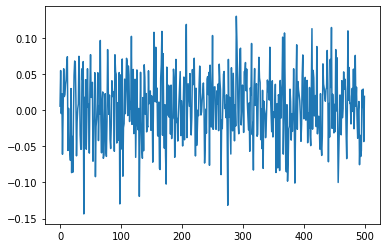

In [33]:
oamp_noise = oamp.n.copy().flatten()
plt.plot(oamp_noise)

In [34]:
for i in range(5):
    sample = test[i].oamps
    Axvar = 0
    nvar = 0
    snr = 0
    for p in range(P):
        Axvar += np.var(sample[p].A_p @ sample[p].x)
        n = sample[p].y - sample[p].A_p @ sample[p].x
        nvar += np.var(n)
        snr += 10*np.log10(np.var(sample[p].A_p @ sample[p].x) / np.var(n))
        print(10*np.log10(np.var(sample[p].A_p @ sample[p].x) / np.var(n)))
    print(10*np.log10(Axvar / nvar))
    print(snr / P)
    print('='*21)

29.546593434330617
30.006199808649786
29.773272772988033
29.7763966214902
29.546593434330617
30.006199808649786
29.773272772988033
29.7763966214902
29.546593434330617
30.006199808649786
29.773272772988033
29.7763966214902
29.546593434330617
30.006199808649786
29.773272772988033
29.7763966214902
29.546593434330617
30.006199808649786
29.773272772988033
29.7763966214902


In [35]:
test_noise = []
for i in range(5):
  n = np.empty(0)
  for p in range(P):
    n = np.append(n, test[i].oamps[p].y - test[i].oamps[p].A_p @ x)
  test_noise.append(n.flatten())

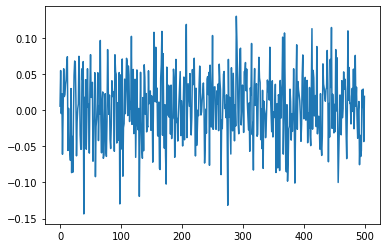

In [36]:
plt.plot(test_noise[0])

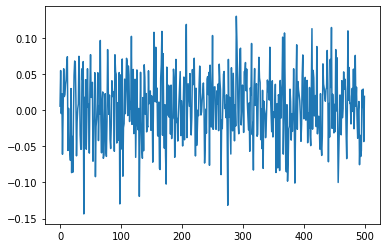

In [37]:
plt.plot(test_noise[1])

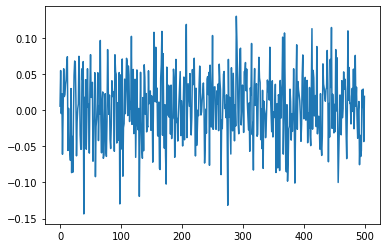

In [38]:
plt.plot(test_noise[2])

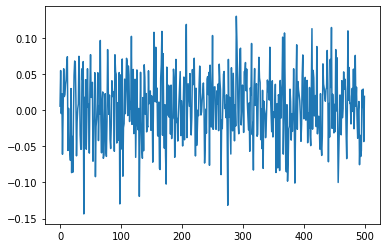

In [39]:
plt.plot(test_noise[3])

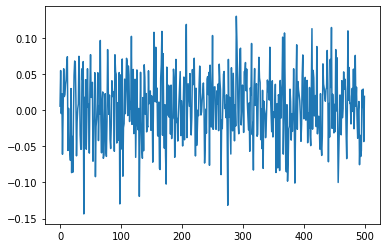

In [40]:
plt.plot(test_noise[4])

In [41]:
for i in range(5):
  norm = np.linalg.norm(oamp_noise - test_noise[i])
  print(norm)

1.5589421060413962e-15
1.5589421060413962e-15
1.5589421060413962e-15
1.5589421060413962e-15
1.5589421060413962e-15


In [63]:
N = 4000  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [64]:
SNR = 60  # 信号対雑音比
SNRdB = 10**(0.1*SNR)
kappa = 5  # 条件数
P = 2  # ノード数
T = 40  # 反復回数
sim = 100  # 実験数

In [65]:
xs = [bernouli_gaussian(N, rho) for _ in range(sim)]
l = 5
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']

In [66]:
MSE_iidG_oamp = np.empty((sim, T+1))

MSE_iidG_test = np.empty((sim, 5, T+1))
CommCost_iidG_test = np.empty((sim, 5, T))

In [67]:
for i in tqdm(range(sim)):
    iidG = iidGaussian(M, N, m=0, v=1/M)
    Ax = iidG.A @ xs[i]
    sigma = np.var(Ax) / SNRdB
    noise = np.random.normal(0, sigma**0.5, (M, 1))

    oamp = D_OAMP(iidG.A, xs[i], noise, 1)
    test = [D_Test(iidG.A, xs[i], noise, P) for _ in range(5)]

    oamp.estimate(T=T)
    MSE_iidG_oamp[i] = oamp.mse

    for j in range(5):
        test[j].estimate(T, gctype=str(j))
        MSE_iidG_test[i, j] = test[j].mse
        CommCost_iidG_test[i, j] = test[j].communication_cost

100%|██████████| 100/100 [11:54:01<00:00, 428.42s/it] 


In [68]:
MSE_iidG_oamp_mean = np.mean(MSE_iidG_oamp, axis=0)

MSE_iidG_test_mean = np.empty((5, T+1))
CommCost_iidG_test_mean = np.empty((5, T))

for i in range(5):
    MSE_iidG_test_mean[i] = np.mean(MSE_iidG_test[:, i], axis=0)
    CommCost_iidG_test_mean[i] = np.mean(CommCost_iidG_test[:, i], axis=0)

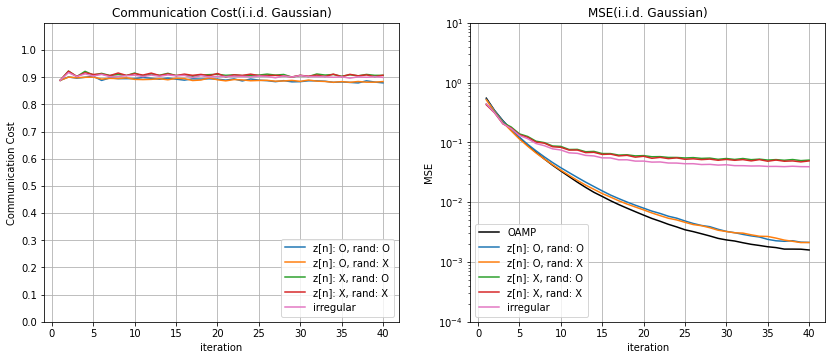

In [70]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt.title('Communication Cost(i.i.d. Gaussian)')
plt_CC(CommCost_iidG_test_mean[0], 'z[n]: O, rand: O', T, N, P, color[0])
plt_CC(CommCost_iidG_test_mean[1], 'z[n]: O, rand: X', T, N, P, color[1])
plt_CC(CommCost_iidG_test_mean[2], 'z[n]: X, rand: O', T, N, P, color[2])
plt_CC(CommCost_iidG_test_mean[3], 'z[n]: X, rand: X', T, N, P, color[3])
plt_CC(CommCost_iidG_test_mean[4], 'irregular', T, N, P, color[4])
plt.grid()

plt.subplot(122)
plt.title('MSE(i.i.d. Gaussian)')
plt_MSE(MSE_iidG_oamp_mean, 'OAMP', T, 'black')
plt_MSE(MSE_iidG_test_mean[0], 'z[n]: O, rand: O', T, color[0])
plt_MSE(MSE_iidG_test_mean[1], 'z[n]: O, rand: X', T, color[1])
plt_MSE(MSE_iidG_test_mean[2], 'z[n]: X, rand: O', T, color[2])
plt_MSE(MSE_iidG_test_mean[3], 'z[n]: X, rand: X', T, color[3])
plt_MSE(MSE_iidG_test_mean[4], 'irregular', T, color[4])
plt.legend(loc="lower left")
plt.grid()

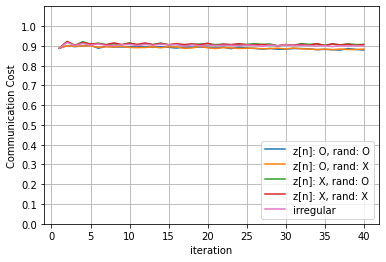

In [71]:
plt_CC(CommCost_iidG_test_mean[0], 'z[n]: O, rand: O', T, N, P, color[0])
plt_CC(CommCost_iidG_test_mean[1], 'z[n]: O, rand: X', T, N, P, color[1])
plt_CC(CommCost_iidG_test_mean[2], 'z[n]: X, rand: O', T, N, P, color[2])
plt_CC(CommCost_iidG_test_mean[3], 'z[n]: X, rand: X', T, N, P, color[3])
plt_CC(CommCost_iidG_test_mean[4], 'irregular', T, N, P, color[4])
plt.grid()

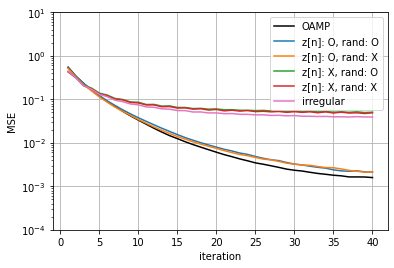

In [72]:
plt_MSE(MSE_iidG_oamp_mean, 'OAMP', T, 'black')
plt_MSE(MSE_iidG_test_mean[0], 'z[n]: O, rand: O', T, color[0])
plt_MSE(MSE_iidG_test_mean[1], 'z[n]: O, rand: X', T, color[1])
plt_MSE(MSE_iidG_test_mean[2], 'z[n]: X, rand: O', T, color[2])
plt_MSE(MSE_iidG_test_mean[3], 'z[n]: X, rand: X', T, color[3])
plt_MSE(MSE_iidG_test_mean[4], 'irregular', T, color[4])
plt.grid()

In [73]:
MSE_UniInv_oamp = np.empty((sim, T+1))

MSE_UniInv_test = np.empty((sim, 5, T+1))
CommCost_UniInv_test = np.empty((sim, 5, T))

In [74]:
for i in tqdm(range(sim)):
    UniInv = UniInvar(M, N, kappa)
    Ax = UniInv.A @ xs[i]
    sigma = np.var(Ax) / SNRdB
    noise = np.random.normal(0, sigma**0.5, (M, 1))

    oamp = D_OAMP(iidG.A, xs[i], noise, 1)
    test = [D_Test(iidG.A, xs[i], noise, P) for _ in range(5)]

    oamp.estimate(T=T)
    MSE_UniInv_oamp[i] = oamp.mse

    for j in range(5):
        test[j].estimate(T, gctype=str(j))
        MSE_UniInv_test[i, j] = test[j].mse
        CommCost_UniInv_test[i, j] = test[j].communication_cost

100%|██████████| 100/100 [19:36:43<00:00, 706.03s/it] 


In [75]:
MSE_UniInv_oamp_mean = np.mean(MSE_UniInv_oamp, axis=0)

MSE_UniInv_test_mean = np.empty((5, T+1))
CommCost_UniInv_test_mean = np.empty((5, T))

for i in range(5):
    MSE_UniInv_test_mean[i] = np.mean(MSE_UniInv_test[:, i], axis=0)
    CommCost_UniInv_test_mean[i] = np.mean(CommCost_UniInv_test[:, i], axis=0)

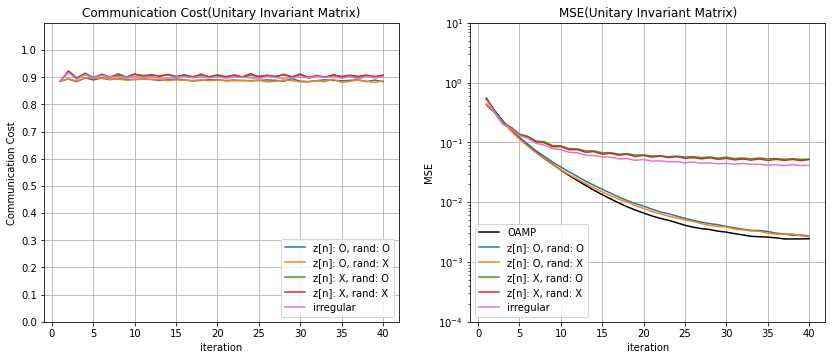

In [76]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt.title('Communication Cost(Unitary Invariant Matrix)')
plt_CC(CommCost_UniInv_test_mean[0], 'z[n]: O, rand: O', T, N, P, color[0])
plt_CC(CommCost_UniInv_test_mean[1], 'z[n]: O, rand: X', T, N, P, color[1])
plt_CC(CommCost_UniInv_test_mean[2], 'z[n]: X, rand: O', T, N, P, color[2])
plt_CC(CommCost_UniInv_test_mean[3], 'z[n]: X, rand: X', T, N, P, color[3])
plt_CC(CommCost_UniInv_test_mean[4], 'irregular', T, N, P, color[4])
plt.grid()

plt.subplot(122)
plt.title('MSE(Unitary Invariant Matrix)')
plt_MSE(MSE_UniInv_oamp_mean, 'OAMP', T, 'black')
plt_MSE(MSE_UniInv_test_mean[0], 'z[n]: O, rand: O', T, color[0])
plt_MSE(MSE_UniInv_test_mean[1], 'z[n]: O, rand: X', T, color[1])
plt_MSE(MSE_UniInv_test_mean[2], 'z[n]: X, rand: O', T, color[2])
plt_MSE(MSE_UniInv_test_mean[3], 'z[n]: X, rand: X', T, color[3])
plt_MSE(MSE_UniInv_test_mean[4], 'irregular', T, color[4])
plt.legend(loc="lower left")
plt.grid()